# CC5215: Privacidad de Datos

## Laboratorio 7

Integrantes:

Francisco Gutiérrez Albornoz

In [24]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

barbie_ratings = pd.read_csv('https://users.dcc.uchile.cl/~darquez/barbie_ratings.csv')

# YOU MAY USE THIS VARIABLES LATER
ratings = barbie_ratings['rating']
weights = barbie_ratings['weight']

## Introduction

In this lab we will work with a dataset of user ratings for the Barbie movie. In particular, we will try out different methods of making a weighted average of the ratings private.

In [25]:
barbie_ratings.head()

,rating,weight
0,4,2
1,10,1
2,5,4
3,6,2
4,5,2


The dataset `barbie_ratings` has two columns: (1) `rating` which correspond to a rating given by a particular viewer, between 1 and 10; and (2) `weight` which corresponds to the importance of the given rating, between 1 and 4, based on previous data about the user (usefulness of other ratings, peer-voting, etc).

**IMPORTANT: Through this lab, it is not necessary that you manually clip the data to the aforementioned bounds. The data is already compliant with the bounds.**

In [26]:
## You may use this variables later:

# Upper bound for ratings
u = 10

# Upper bound for weights
wu = 4

## Question 1 (4 points)

The weighted average formula is defined as:

$$
\frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^n w_i}
$$

Where $w_i$ and $x_i$ in the ratings dataset corresponds to the the weight and rating of viewer $i$ respectively.
(Notice that when all the weights $w_i$ are $1$, the weighted average is equivalent to the regular average)

**Write a function that calculates the weighted average of a dataset**:

In [27]:
def weighted_avg(data, weights):
    """
        Parameters:
            data (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
        Returns:
            The `weights`-weighted average of `data`
    """
    sum_w_x = sum([ data.iloc[i]*weights.iloc[i] for i in range(len(data))])
    sum_w = weights.sum()
    return sum_w_x / sum_w



weighted_avg(ratings, weights)

np.float64(5.484507042253521)

## Question 2 (6 points)

Write a differentially private version of `weighted_avg`, using global sensitivity.

In [28]:
s_wx = 40
s_w = 4
def gs_weighted_avg(data, weights, data_ub, weight_ub, epsilon):
    """
        Parameters:
            data (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            epsilon (float): The privacy budget
        Returns:
           The private `weights`-weighted average of `data`
    """
    weights_clipped = weights.clip(upper=weight_ub)
    data_clipped = data.clip(upper=data_ub)
    sum_w_x = sum([ data_clipped.iloc[i]*weights_clipped.iloc[i] for i in range(len(data))])
    sum_w = weights_clipped.sum()
    sum_w_x_dp = laplace_mech(sum_w_x, s_wx, epsilon / 2) #40 porque el max w es 4 y max x es 10 
    sum_w_dp = laplace_mech(sum_w, s_w, epsilon / 2)
    return sum_w_x_dp / sum_w_dp
gs_weighted_avg(ratings, weights, u, wu, 0.1)

np.float64(5.290797939699224)

**Explain why your implementation is `epsilon`-DP**.

Porque utilizo composición secuencial para calcular la suma de $w*x$ y $w$ considerando privacidad diferencial, cada suma utiliza $\epsilon /2$.

## Question 3 (6 points)

Calculate the local sensitivity of the weighted average.


YOUR ANSWER:

(Complete the following)

Given
$$
f(x, w) = \frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^n w_i}
$$

If we add a row:

$$
\begin{align}
|f(x, w) - f(x', w')| &= \left | \frac{u_w * u_x + \sum_{i=1}^n w_i * x_i}{u_w + \sum_{i=1}^n w_i} - \frac{\sum_{i=1}^n w_i * x_i}{\sum_{i=1}^n w_i} \right | \\
                      &\leq \left | \frac{u_w * u_x + \sum_{i=1}^n w_i * x_i}{u_w + \sum_{i=1}^n w_i} - \frac{\sum_{i=1}^n w_i * x_i}{ u_w + \sum_{i=1}^n w_i} \right | \\
                      &= \left | \frac{u_w * u_x}{u_w + \sum_{i=1}^n w_i} \right |
\end{align}
$$

donde $u_w$ y $u_x$ son los upper bounds para el $w$ y $x$ respectivamente.

## Question 4 (9 points)

As we saw in class, even though local sensitivity gives us a better upper bound than global sensitivity, we cannot directly use it with the mechanisms we have seen (e.g. laplace).

We will implement the Propose-Test-Release method for calculating a private weighted average of `barbie_ratings`. In order to do that, follow the next steps:

1. Implement a function to compute the *Maximum Local Sensitivity* at distance k:

In [29]:
def ls_at_distance(target_ub, weight_ub, W, k):
    """
        Parameters:
            target_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            W (int): The sum of the weights of the origin dataframe
            k (int): The number of steps away from the origin dataframe
        Returns:
            The maximized local sensitivity between `df` and a dataframe at `k` steps
    """
    return np.abs(target_ub * weight_ub / (W - k * weight_ub))

2. Implement a function to find the minimum number of steps to achieve a local sensitivity of at least $b$:

*Hint: Start by trying with $k=0$, and increment $k$ until the threshold of $b$ is achieved*

In [30]:
def dist_to_high_ls(target_ub, weight_ub, W, b):
    """
        Parameters:
            target_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            W (int): The sum of the weights of the origin dataframe
            b (float): The proposed bound on local sensitivity
        Returns:
            The minimum number of steps to achieve a local sensitivity of at least `b`
    """
    k = 0
    while ls_at_distance(target_ub, weight_ub, W, k) < b:
        k+=1
    return k

3. Implement the PTR version of weighted average:

In [31]:
def ptr_weighted_avg(data, weights, data_ub, weight_ub, b, epsilon, delta):
    """
        Parameters:
            data    (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            b (float): The proposed bound on local sensitivity
            epsilon, delta: The level of privacy
        Returns:
            The private weighted average using PTR
    """
    data_clipped = data.clip(upper=data_ub)
    weights_clipped = weights.clip(upper=weight_ub)
    k = dist_to_high_ls(data_ub, weight_ub, weights_clipped.sum(), b)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2 / delta) / (2 * epsilon)

    if noisy_distance >= threshold:
        return laplace_mech(weighted_avg(data_clipped, weights_clipped), b, epsilon)
    return None

In [32]:
ptr_weighted_avg(ratings, weights, u, wu, 0.02, 1.0, 10e-6)

np.float64(5.496690531555193)

## Question 5 (4 points)

The following code plots the relative errors (against the real answer) of global sensitivity and PTR:

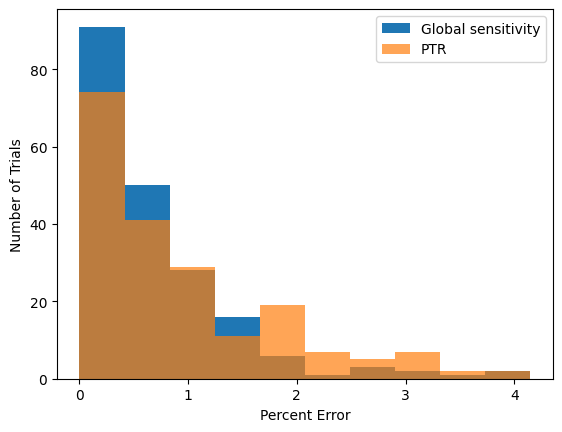

In [33]:
epsilon = 1.0
delta = 10e-6
b = 0.05

gs_errors = []
ptr_errors = []

real_avg = weighted_avg(ratings, weights)

for i in range(200):
    ptr_result = ptr_weighted_avg(ratings, weights, u, wu, b, epsilon, delta)

    gs_result = gs_weighted_avg(ratings, weights, u, wu, epsilon)
    gs_errors.append(pct_error(real_avg, gs_result))

    if ptr_result is None:
        continue

    ptr_errors.append(pct_error(real_avg, ptr_result))

_, bins, _ = plt.hist(gs_errors, label='Global sensitivity');
plt.hist(ptr_errors, alpha=.7, label='PTR', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

1. Compare the accuracies of both methods. Which one is better? Explain how the plot helps justifying your analysis.
2. What can you say about the parameter $b$, in terms of the usability of the PTR method? How does this aspect compare to the global sensitivity method?

1. Los errores porcentuales asociados a GS están concentrados más cerca de 0 comparado con PTR. Para este último, se tiene un error más distribuido lo que significa que se agrega más ruido. Debido a esto sería mejor GS, en clases vimos lo contrario y puede deberse al valor dado para b.
2. Es la máxima sensibilidad local permitida para aplicar el mecanismo de laplace en el método PTR. Con esto podemos evaluar si aceptar o no una consulta, en cambio con la sensibilidad global nunca se rechazan. Por esto, la sensibilidad global tiende a ser más robusta pero sobreestimar el ruido necesario.

## Question 6 (3 points)

Now, we will implement the weighted average using the Smooth Sensitivity framework.

First, implement `smooth_ls_at_distance`, which calculates the local sensitivity at distance $k$, smoothed out by an exponential factor of $e^{-\beta k}$:

In [34]:
def smooth_ls_at_distance(data_ub, weight_ub, W, k, beta):
    """
        Parameters:
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            W (int): The sum of the weights of the origin dataframe
            k (int): The number of steps away from the origin dataframe
            beta (float): The smooth factor
        Returns:
            The smoothed local sensitivity at distance k
    """
    return np.exp(- beta * k) * ls_at_distance(data_ub, weight_ub, W, k)

## Question 7 (2 points)

1. What does the following graph shows?
2. What information can we infer from this plot to help us implement a weighted average using smooth sensitivity?

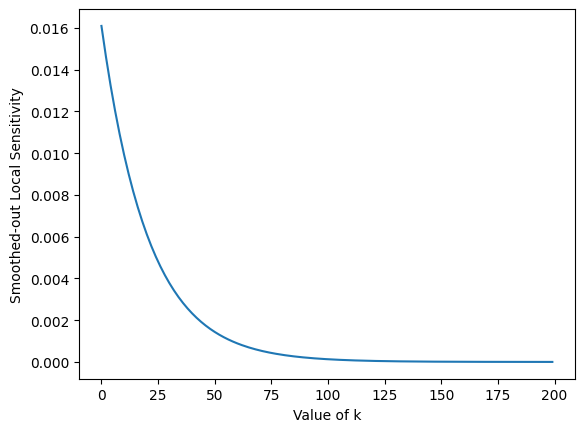

In [35]:
beta = 0.05

r = [smooth_ls_at_distance(u, wu, weights.sum(), k, beta) for k in range(0, 200)]

plt.plot(r);
plt.xlabel('Value of k')
plt.ylabel('Smoothed-out Local Sensitivity');

1. Se muestra cómo varía la sensibilidad local suave a medida que aumenta el k, es decir la distacia del dataset. Se observa que esta curva es estrictamente decreciente y por lo tanto su máximo valor es para $k=0$.
2. Como la contribución para valores de k grandes es muy pequeña, basta con analizar valores pequeños de k (< 100 en este caso).

## Question 8 (6 points)

Implement the query using Smooth Sensitivity:

In [ ]:
def ss_weighted_avg(data, weights, data_ub, weight_ub, epsilon, delta):
    """
        Parameters:
            data    (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            data_ub (int): The upper bound of the target column
            weight_ub (int): The upper bound of the weight column
            epsilon, delta: The level of privacy
        Returns:
            The private weighted average using Smooth Sensitivity
    """
    data_clipped = data.clip(upper=data_ub)
    weights_clipped = weights.clip(upper=weight_ub)
    epsilon_beta = epsilon / 2
    beta = epsilon_beta / (2 * np.log (2 / delta))
    r = [smooth_ls_at_distance(u, wu, weights.sum(), k, beta) for k in range(0, len(data))]
    S = np.max(r)
    epsilon_laplace = epsilon - epsilon_beta
    return laplace_mech(weighted_avg(data_clipped, weights_clipped), 2 * S, epsilon_laplace)

ss_weighted_avg(ratings, weights, u, wu, epsilon, delta)

np.float64(5.390890184346727)

## Question 9 (4 points)

The following code plots the relative errors (against the real answer) of global sensitivity and Smooth Sensitivity:

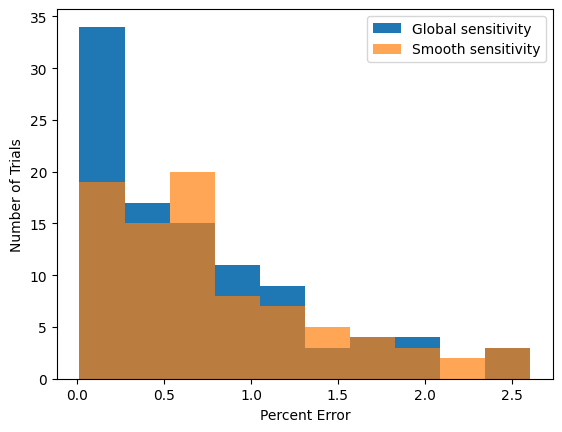

In [47]:
gs_results  = [
    pct_error(weighted_avg(ratings, weights),
    gs_weighted_avg(ratings, weights, u, wu, epsilon)) for i in range(100)]
ptr_results = [
    pct_error(weighted_avg(ratings, weights),
    ss_weighted_avg(ratings, weights, u, wu, epsilon, delta)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='Global sensitivity');
plt.hist(ptr_results, alpha=.7, label='Smooth sensitivity', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

1. Compare the accuracies of both methods. Explain how the plot helps justifying your analysis.
2. What disadvantage has this method when comparing it with the global sensitivity approach?

*Respuestas*
1. Los errores observados son muy similares, smooth sensivity muestra una menor cantidad de errores porcentuales pequeños (cercanos a cero) comparado con global sensitivity. Esto indica una leve mejor precisión para global sensitivity.
2. Computacionalmente es más costoso pues se itera sobre una gran cantidad de valores para $k$

## Question 10 (6 points)

Let us define a function that receives $k$ results, computed from **disjoint** sets of data, and calculates the clipped (by $l$ and $u$) average between them as follows:

$$
g_{l,u}(x) = \frac{\sum^k_{i=1} \mathsf{clip}(x_i, l, u)}{k}
$$

where $x$ is a vector that represent the average of each disjoint set of data.

**Calculate the global sensitivity of $g_{l,u}$.**

*Hint: Use the fact that the computations x_i are disjoint*

Complete:

$$
\begin{align*}
|g_{l,u}(x) - g_{l,u}(x')| &= \left | \frac{(u - l) + \sum^k_{i=1} \mathsf{clip}(x_i, l, u)}{k + 1} - \frac{\sum^k_{i=1} \mathsf{clip}(x_i, l, u)}{k} \right |\\
                           &\leq  \left | \frac{(u - l) + \sum^k_{i=1} \mathsf{clip}(x_i, l, u)}{k + 1} - \frac{\sum^k_{i=1} \mathsf{clip}(x_i, l, u)}{k + 1} \right | \\
                           &= \left | \frac{u - l}{k + 1} \right |
\end{align*}
$$

## Question 11 (6 points)

Implement the Sample & Aggregate framework for weighted averages, using $g$ as your aggregation function.

*Hint: Use the function `np.array_split` to divide the dataframe in $k$ chunks.*

In [ ]:
def sa_weighted_avg(data, weights, k, l, u, epsilon):
    """
        Parameters:
            data    (pd.Series): The data to average
            weights (pd.Series): The weights to calculate the average
            k (int): The number of chunks
            l, u (int): The clipping parameters for dividing the partial averages
            epsilon (float): The privacy budget
        Returns:
            The private weighted average using Sample & Aggregate
    """
    data_chunks = np.array_split(data, k)
    weights_chunks = np.array_split(weights, k)
    answers = [weighted_avg(d, w) for d,w in zip(data_chunks, weights_chunks)]
    clipped_answers = np.clip(answers, l, u)
    noisy_avg = laplace_mech(np.mean(clipped_answers), (u - l) / k, epsilon)
    return noisy_avg

sa_weighted_avg(ratings, weights, 200, 2, 8, epsilon)

np.float64(5.4885201694532055)

## Question 12 (4 points)

The following code plots the relative errors (against the real answer) of global sensitivity and Smooth Sensitivity:

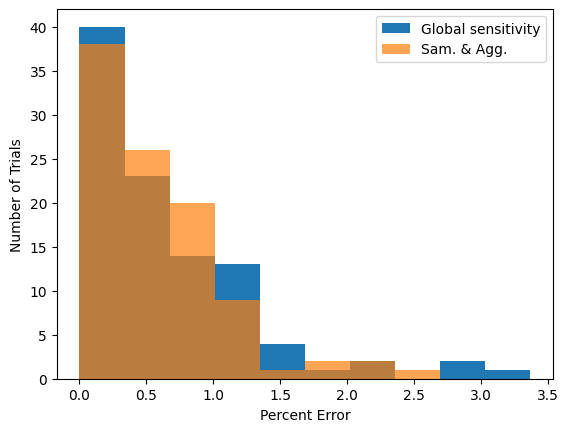

In [39]:
gs_results  = [
    pct_error(weighted_avg(ratings, weights),
    gs_weighted_avg(ratings, weights, u, wu, epsilon)) for i in range(100)]
ptr_results = [
    pct_error(weighted_avg(ratings, weights),
    sa_weighted_avg(ratings, weights, 200, 2, 8, epsilon)) for i in range(100)]

_, bins, _ = plt.hist(gs_results, label='Global sensitivity');
plt.hist(ptr_results, alpha=.7, label='Sam. & Agg.', bins=bins);
plt.xlabel('Percent Error')
plt.ylabel('Number of Trials')
plt.legend();

1. Compare the accuracies of both methods. Explain how the plot helps justifying your analysis.
2. We used bounds of $(2,8)$ as clipping parameters for the intermediate averages. Do you think those are reasonable bounds? Why?

YOUR ANSWER
1. Se observa que Sample and aggregate obtiene mayor precisión debido a que los errores porcentuales están más concentrados y cercanos a cero en cambio para Global sensitivity los errores están más dispersos.
2. Recortar los bordes puede ayudar a ignorar valores que podrían resultar atípicos, pero esto puede reducir la precisión. Considerando esto último, estos límites parecen razonable porque no se reduce demasiado el intervalo de valores que se podría tomar.